In [1]:
import os
from pathlib import Path
compe='spooky-author-identification'
is_kaggle=os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if is_kaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{compe}.zip').extractall(path)

In [2]:
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [3]:
os.listdir('spooky-author-identification')

['test.zip', 'sample_submission.zip', 'train.zip']

In [4]:
df=pd.read_csv(f'{compe}/train.zip')
df_test=pd.read_csv(f'{compe}/test.zip')
df_sub=pd.read_csv(f'{compe}/sample_submission.zip')
df.shape,df_test.shape

((19579, 3), (8392, 2))

In [5]:
df.head(4)

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS


In [6]:
df_sub.head(2)

,id,EAP,HPL,MWS
0,id02310,0.40,0.29,0.31
1,id24541,0.40,0.29,0.31


### EDA

In [7]:
df.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

> So basically its multi class classification pblm - (classes=3)

In [8]:
df['text'].describe()

count                                                                                                                                                                                                                                       19579
unique                                                                                                                                                                                                                                      19579
top       This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
freq                                                                                                                                                                                                                                            1
Name: text, dtype: object

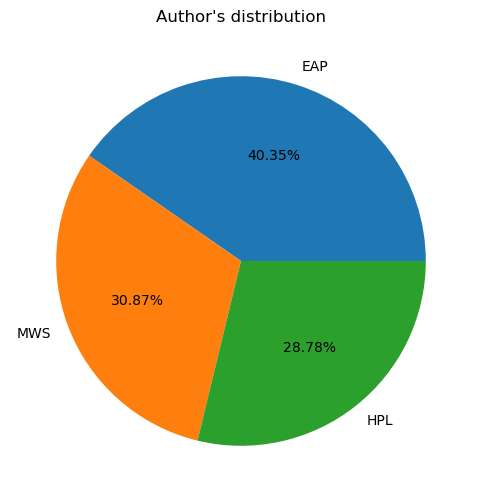

Shape is  (19579, 3)


In [20]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,1,figsize=(10,6))
text_author_counts = df['author'].value_counts()
axs.pie(text_author_counts, labels=text_author_counts.index, autopct='%1.2f%%')
axs.set_title("Author's distribution")
plt.show()
print('Shape is ',df.shape)

In [11]:
text_author_counts = df['author'].value_counts()
text_author_counts

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [22]:
byAuthor = df.groupby("author")


,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL
5,id22965,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",MWS


In [59]:
df.groupby("author").size()

author
EAP    7900
HPL    5635
MWS    6044
dtype: int64

In [60]:
import nltk

In [61]:
byAuthor=df.groupby('author')
wordFreqByAuthor = nltk.probability.ConditionalFreqDist()

In [75]:
for name,group in byAuthor:
    sentences=group['text'].str.cat(sep=' ')
    sentences=sentences.lower()
    tokens=nltk.tokenize.word_tokenize(sentences)
    frequency = nltk.FreqDist(tokens)
    wordFreqByAuthor[name] = (frequency)
#     print(frequency)
#     break


In [77]:
wordFreqByAuthor['EAP']

FreqDist({',': 17594, 'the': 14969, 'of': 8970, '.': 7634, 'and': 5733, 'to': 4761, 'a': 4711, 'in': 4124, 'i': 3780, 'that': 2327, ...})

In [80]:
wordFreqByAuthor['EAP'].freq(',')

0.07581137213671384

In [ ]:
testSentence = "It was a dark and stormy night."
testSentence=testSentence.lower()
testSentence_processed=nltk.tokenize.word_tokenize(sentences)